In [164]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Author: Andrew Tarzia

Date Created: 05 Aug 2018

License:

# Notebook to analyse all enzymes used in ZIF-8 experiments using BRENDA database

TODO:
- add license
- modifications
    - introduce exposure consideration
        - get another method for calculating exposure without structure?
    - generalise code to multiple target residues ("targ = convert_to_one_letter_code_sing('target_res')" needs to act on a list

In [2]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Alphabet import IUPAC
from rdkit.Chem.Draw import IPythonConsole  # to show molecules in notebook
import time
import numpy as np
# ensure cpickle usage
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors3D import NPR1, NPR2, PMI1, PMI2, PMI3
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Geometry import rdGeometry
from rdkit.Chem import PyMol
from rdkit import Geometry
import tempfile
%aimport pi_fn
%aimport parameters
%aimport brenda_IO
%aimport SABIO_IO
%aimport rdkit_functions
%aimport ellipsoid

# Calculate pI of all sequences in EC No. used in literature
## Produces distribution for each EC No.

## Notes:
### Biopython:
- pK values and the methods are taken from::
    * Bjellqvist, B.,Hughes, G.J., Pasquali, Ch., Paquet, N., Ravier, F.,
    Sanchez, J.-Ch., Frutiger, S. & Hochstrasser, D.F.
    The focusing positions of polypeptides in immobilized pH gradients can be
    predicted from their amino acid sequences. Electrophoresis 1993, 14,
    1023-1031.
    * Bjellqvist, B., Basse, B., Olsen, E. and Celis, J.E.
    Reference points for comparisons of two-dimensional maps of proteins from
    different human cell types defined in a pH scale where isoelectric points
    correlate with polypeptide compositions. Electrophoresis 1994, 15, 529-539.

|  AA | pKa  |
|-----|------|
| ASP | 4.05 |
| GLU | 4.45 |
| HIS | 5.98 |
| CYS | 9.00 |
| TYR | 10.0 |
| LYS | 10.0 |
| ARG | 12.0 |
| N-terminus | 7.50 |
| N-terminus : GLU | 7.7 |
| N-terminus : VAL | 7.44 |
| N-terminus : THR | 6.82 |
| N-terminus : PRO | 8.36 |
| N-terminus : SER | 6.93 |
| N-terminus : MET | 7.00 |
| N-terminus : ALA | 7.59 |
| C-terminus | 3.55 |
| C-terminus : ASP | 4.55 |
| C-terminus : GLU | 4.75 |

- with the above pKas and the data set in Tash's paper (DOI:) we apply a pI cut off = XX.


### Modified pIs:
- assuming sequence only and therefore cannot use DSSP to calculate exposure

In [3]:
# get parameters
param_dict = parameters.get_parameters()

# input parameters
database_directory = '/home/atarzia/psp/sequence_db/bio_min_dataset/'
output_dir = database_directory

In [4]:
# set EC numbers of interest based on dataset
# 'none' in species lists implies species was not given with literature report.
EC_set = {
    # EC : species list
    '1.11.1.5': ['equus caballus', ],
    '1.11.1.6': ['bos taurus', ],
    '1.11.1.7': ['armoracia rusticana', ],
    '1.9.3.1': ['equus caballus', ],
    '1.1.5.2': ['none', ],
    '3.5.1.5': ['canavalia ensiformis'],
    '1.1.3.4': ['aspergillus niger'],
    '1.13.12.4': ['none'],
    '3.2.1.26': ['none'],
    '3.1.1.3': ['thermomyces lanuginosus', 'alcaligenes sp.',
                'pseudomonas fluorescens',
                'rhizomucor miehei', 'candida antarctica',
                'aspergillus niger'],
    '3.1.1.6': ['lactobacillus acidophilus'],
    '3.5.1.11': ['none'],
    }

In [5]:
# get input FASTA file names
database_names = []
for i in glob.glob(database_directory+"*fasta"):
    if "_mod" not in i:
        database_names.append(i)
database_names = sorted(database_names)
print('databases:')
for i in database_names:
    print('--', i.replace(database_directory, ''))

# prepare output CSV file
redo_pi = input('redo pI calculation (True = yes, False = no)')
if redo_pi == 'True':
    redo_pi = True
    pi_fn.prepare_out_csv(output_dir, param_dict)
    # fix formatting of FASTA files to match BIOPYTHON readable
    pi_fn.fix_fasta(database_names)

databases:
-- 1_11_1_5__BRENDA_sequences.fasta
-- 1_11_1_6__BRENDA_sequences.fasta
-- 1_11_1_7__BRENDA_sequences.fasta
-- 1_13_12_4__BRENDA_sequences.fasta
-- 1_1_3_4__BRENDA_sequences.fasta
-- 1_1_5_2__BRENDA_sequences.fasta
-- 1_9_3_1__BRENDA_sequences.fasta
-- 3_1_1_3__BRENDA_sequences.fasta
-- 3_1_1_6__BRENDA_sequences.fasta
-- 3_2_1_26__BRENDA_sequences.fasta
-- 3_5_1_11__BRENDA_sequences.fasta
-- 3_5_1_5__BRENDA_sequences.fasta
redo pI calculation (True = yes, False = no)False


calculate all pIs for target EC sequences
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_5__BRENDA_sequences.fasta
--- finished 2220 sequences in 0.69 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_6__BRENDA_sequences.fasta
--- finished 22068 sequences in 7.67 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_7__BRENDA_sequences.fasta
--- finished 16288 sequences in 4.23 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_13_12_4__BRENDA_sequences.fasta
--- finished 379 sequences in 0.12 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_1_3_4__BRENDA_sequences.fasta
--- finished 36 sequences in 0.02 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_1_5_2__BRENDA_sequences.fasta
--- finished 1765 sequences in 0.67 seconds ---
plot d

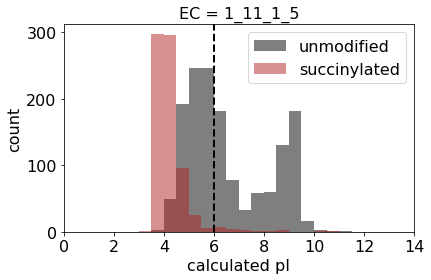

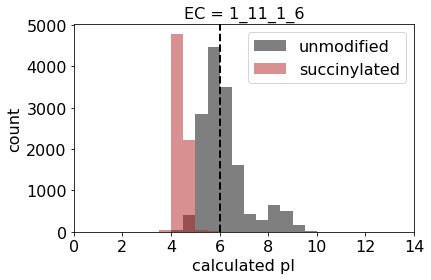

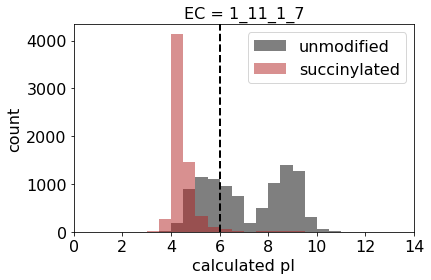

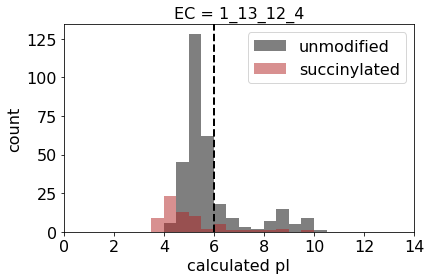

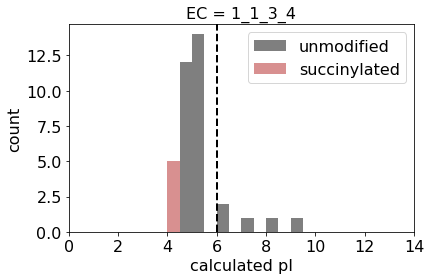

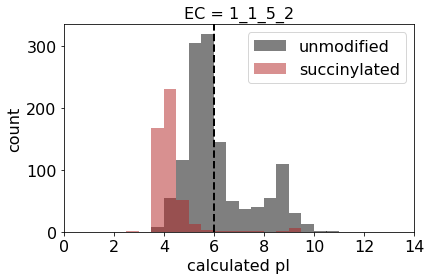

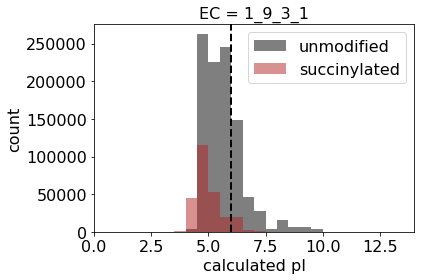

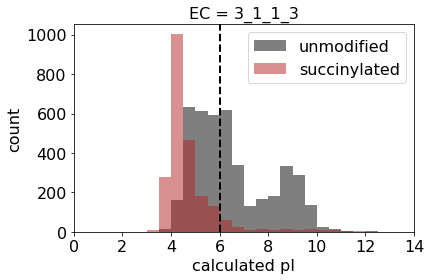

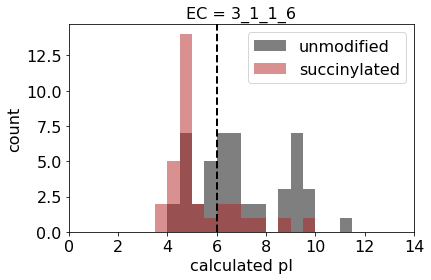

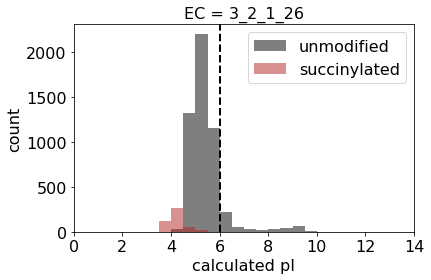

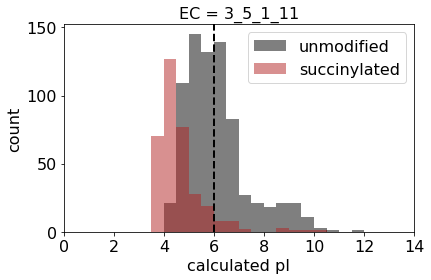

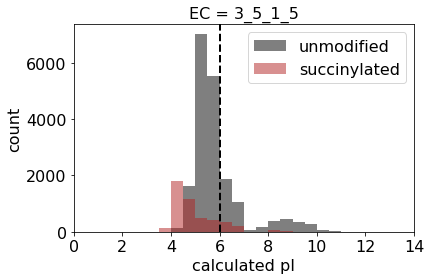

In [9]:
print('calculate all pIs for target EC sequences')
for EC_file in database_names:
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    print('doing:', EC_file)
    file_mod = EC_file.replace(".fasta", "_mod.fasta")
    if redo_pi is True:
        pi_fn.calculate_pI_from_file(file_mod, param_dict, output_dir)
    print('plot distribution of pIs')
    pi_data = pd.read_csv(output_dir+param_dict['out_CSV_pi'], index_col=False)
    EC_pi_data = pi_data[pi_data['fasta_file'] == file_mod]
    pi_fn.plot_EC_pI_dist(EC_pi_data, param_dict,
                          filename=file_mod.replace('.fasta', '.pdf'),
                          title=file_mod.replace(output_dir, '').replace('__BRENDA_sequences_mod.fasta', ''))
    print('done')

(0, 30000)

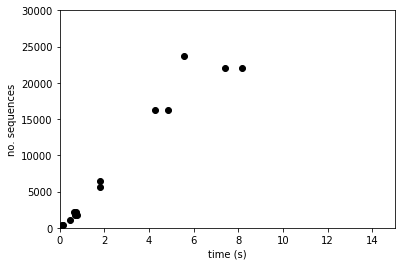

In [10]:
times = [0.74, 8.18, 4.85, 0.13, 0.02, 0.78, 
         0.62, 7.42, 4.26, 0.11, 0.01, 0.67, 
         300.89, 1.81, 0.03, 1.82, 0.44, 5.56]
seqs = [2220, 22068, 16288, 379, 36, 1765, 2220,
        22068, 16288, 379, 36, 1765, 1253592,
        6487, 80, 5665, 1098, 23660]
plt.scatter(times, seqs, c='k')
plt.xlabel('time (s)')
plt.ylabel('no. sequences')
plt.xlim(0, 15)
plt.ylim(0, 30000)

# Collect pI of species used in Literature data base using BRENDA

In [11]:
# get parameters
param_dict = parameters.get_parameters()

# input parameters
database_directory = '/home/atarzia/psp/sequence_db/bio_min_dataset/'
output_dir = database_directory

In [12]:
# set EC numbers of interest based on dataset
# 'none' in species lists implies species was not given with literature report.
EC_set = {
    # EC : species list
    '1.11.1.5': ['equus caballus', ],
    '1.11.1.6': ['bos taurus', ],
    '1.11.1.7': ['armoracia rusticana', ],
    '1.9.3.1': ['equus caballus', ],
    '1.1.5.2': ['none', ],
    '3.5.1.5': ['canavalia ensiformis'],
    '1.1.3.4': ['aspergillus niger'],
    '1.13.12.4': ['none'],
    '3.2.1.26': ['none'],
    '3.1.1.3': ['thermomyces lanuginosus', 'alcaligenes sp.',
                'pseudomonas fluorescens',
                'rhizomucor miehei', 'candida antarctica',
                'aspergillus niger'],
    '3.1.1.6': ['lactobacillus acidophilus'],
    '3.5.1.11': ['none'],
    }

In [13]:
# read in pI output file
pi_data = pd.read_csv(output_dir+param_dict['out_CSV_pi'], index_col=False)

In [14]:
print('Screen all Enzymes in EC Classes using BRENDA data')
count_done = 0
total_start_time = time.time()
for EC_file in database_names:
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    print('-----------------------------------------------')
    print('doing:', EC_file)
    file_mod = EC_file.replace(".fasta", "_mod.fasta")
    EC_pi_data = pi_data[pi_data['fasta_file'] == file_mod]
    # only keep those that pass the pI test
    pi_passed_data = EC_pi_data[EC_pi_data['pi'] < param_dict['cutoff_pi']]
    print('--- ', 
          len(pi_passed_data), 'proteins out of', len(EC_pi_data), 
          'remain, OR', int(len(pi_passed_data)/len(EC_pi_data)*100),
          "% ---")
    EC_no = list(set(EC_pi_data['EC.code']))[0].replace(' ', '').replace(".", "_")
    print('EC:', EC_no.replace("_", "."))
    br_datafile = 'brenda_download_'+EC_no+'.txt'
    # convert br_datafile into dictionary
    br_symbols, br_data = brenda_IO.get_brenda_dict(param_dict['BRENDA_DB_loc']+br_datafile)
    # from here is quite bio-min assay literature specific - although the code can be reused
    # get species of interest from known EC records
    species_of_interest = EC_set[EC_no.replace('_', '.')]
    for spec in species_of_interest:
        print('species:', spec)
        # is species in sequence data?
        spec_in_seq, spec_in_br = brenda_IO.is_species_reported(spec, 
                                                                EC_pi_data, 
                                                                br_data, 
                                                                verbose=True)
        PR_of_int = []
        for i in sorted(br_data['PR']):
            if spec in i.lower():
                # this assumes that the first item of each line is always "#"
                PR_info = i.split("#")[1]            
                if PR_info not in PR_of_int:
                    PR_of_int.append(PR_info)
        # get pI from BRENDA
        prop_of_int = 'PI'
        list_of_int = br_data[prop_of_int]
        # get list of protein codes with property of interest
        EC_prop_PR_codes = brenda_IO.get_prop_PR_codes(list_of_int)
        value_of_int = {}
        for PR in PR_of_int:
            if PR in set([j for i in EC_prop_PR_codes.values() for j in i ]):
                print('protein code:', PR, 'has', prop_of_int, 'in BRENDA')
            else:
                print('protein code:', PR, 'does not have', prop_of_int, 'in BRENDA')
            values = [list_of_int[i].split(" ")[1] 
                      for i in EC_prop_PR_codes.keys() if PR in EC_prop_PR_codes[i]]
            # apply property specific rules
            # check for ranges - append min and max
            values_min = [i.split('-')[0] for i in values if '-' in i and i[0] != '-']
            values_max = [i.split('-')[1] for i in values if '-' in i and i[0] != '-']
            if len(values_min) > 0 and len(values_max) > 0:
                for i in np.arange(len(values)-1, -1, -1):
                    if '-' in values[i]:
                        del values[i]
                print(values_min, values_max)
                values.append(values_min[0])
                values.append(values_max[0])
            # PI == float
            values = [float(i) for i in values]
            # PI => between 0 and 14
            values = [i for i in values if i >= 0 and i <= 14]
            if len(values) > 0:
                value_of_int[PR] = values
        print('reported pIs in BRENDA:', value_of_int.values())
    count_done += 1
print('--- finished %s EC classes in %s seconds ---' % (count_done, '{0:.2f}'.format(time.time() - total_start_time)))

Screen all Enzymes in EC Classes using BRENDA data
-----------------------------------------------
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_5__BRENDA_sequences.fasta
---  1459 proteins out of 2220 remain, OR 65 % ---
EC: 1.11.1.5
species: equus caballus
species in sequence data: False
species in BRENDA data: False
reported pIs in BRENDA: dict_values([])
-----------------------------------------------
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_6__BRENDA_sequences.fasta
---  14865 proteins out of 22068 remain, OR 67 % ---
EC: 1.11.1.6
species: bos taurus
species in sequence data: True
species in BRENDA data: True
protein code: 12 has PI in BRENDA
protein code: 138 does not have PI in BRENDA
reported pIs in BRENDA: dict_values([[5.4]])
-----------------------------------------------
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_7__BRENDA_sequences.fasta
---  9633 proteins out of 16288 remain, OR 59 % ---
EC: 1.11.1.7
species: armoracia rus

# From the list of reactions reported in the literature - determine, which molecules fit in ZIF-8

In [3]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticklabels(['diffuses', 'does not diffuse'])
    ax.set_xticks([0.25, 0.75])


def define_parity_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


In [4]:
# set EC numbers of interest based on dataset
# 'none' in species lists implies species was not given with literature report.
EC_mol_set = {
    # EC : species list : unique molecules
    '1.11.1.5': {'equus caballus': [
        ('hydrogen peroxide', 'OO'),
        ('pyrogallol', 'C1=CC(=C(C(=C1)O)O)O'),
        ('purporogallin', 'C1=CC(=O)C(=C2C(=C1)C=C(C(=C2O)O)O)O'),
    ]},
    '1.11.1.6': {'bos taurus': [
        ('hydrogen peroxide', 'OO'),
        ('water', 'O'),
        ('oxygen', 'O=O'),
        ('3-amino-1,2,4-triazole', 'C1=NNC(=N1)N'),
    ]},
    '1.11.1.7': {'armoracia rusticana': [
        ('pyrogallol', 'C1=CC(=C(C(=C1)O)O)O'),
        ('purporogallin', 'C1=CC(=O)C(=C2C(=C1)C=C(C(=C2O)O)O)O'),
        ('hydrogen peroxide', 'OO'),
        ('water', 'O'),
        ('oxygen', 'O=O'),
        ('ABTS', 'CCN1C2=C(C=C(C=C2)S(=O)(=O)[O-])SC1=NN=C3N(C4=C(S3)C=C(C=C4)S(=O)(=O)[O-])CC'),
    ]},
    '1.9.3.1': {'equus caballus': [
        ('hydrogen peroxide', 'OO'),
        ('water', 'O'),
        ('oxygen', 'O=O'),
        ('ABTS', 'CCN1C2=C(C=C(C=C2)S(=O)(=O)[O-])SC1=NN=C3N(C4=C(S3)C=C(C=C4)S(=O)(=O)[O-])CC'),
        ('Amplex Red', 'CC(=O)N1C2=C(C=C(C=C2)O)OC3=C1C=CC(=C3)O'),
        ('resorufin', 'C1=CC2=C(C=C1O)OC3=CC(=O)C=CC3=N2'),
        ('methyl ethyl ketone peroxide', 'CCC(C)(OO)OOC(C)(CC)OO'),
        ('tert-butyl hydroperoxide', 'CC(C)(C)OO'),
    ]},
    '1.1.5.2': {'none': [
        ('methosulfate', 'COS(=O)(=O)[O-]'),
        ('5-Methylphenazin-5-ium', 'C[N+]1=C2C=CC=CC2=NC3=CC=CC=C31'),
        ('2,6-dichloroindophenol', 'C1=CC(=O)C=CC1=NC2=CC(=C(C(=C2)Cl)O)Cl'),
    ]},
    '3.5.1.5': {'canavalia ensiformis': [
        ('Urea', 'C(=O)(N)N'),
        ('water', 'O'),
        ('carbon dioxide', 'C(=O)=O'),
        ('ammonia', 'N'),
    ]},
    '1.1.3.4': {'aspergillus niger': [
        ('D-glucose (chain)', 'C(C(C(C(C(C=O)O)O)O)O)O'),
        ('D-glucose (ring)', 'C(C1C(C(C(C(O1)O)O)O)O)O'),
        ('gluconic acid', 'C(C(C(C(C(C(=O)O)O)O)O)O)O'),
        ('hydrogen peroxide', 'OO'),
        ('Gluconolactone', 'C(C1C(C(C(C(=O)O1)O)O)O)O'),
    ]},
    '1.13.12.4': {'none': [
        ('hydrogen peroxide', 'OO'),
        ('pyruvate', 'CC(=O)C(=O)[O-]'),
        ('L-lactate', 'CC(C(=O)[O-])[O-]'),
        
    ]},
    '3.2.1.26': {'none': [
        ('sucrose', 'C(C1C(C(C(C(O1)OC2(C(C(C(O2)CO)O)O)CO)O)O)O)O'),
        ('L-fructose', 'C(C(C(C(C(=O)CO)O)O)O)O'),
        ('D-fructose', 'C1C(C(C(C(O1)(CO)O)O)O)O'),
    ]},
    '3.1.1.3': {'thermomyces lanuginosus': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ],
                'alcaligenes sp.': [  # not sure about this one - the kinetic resolution may not belong to this enyzme?
                    ('2-octanol', 'CCCCCCC(C)O'),
                    ('vinyl acetate', 'CC(=O)OC=C'),
                    ('octyl acetate', 'CCCCCCCCOC(=O)C'),
                    ('p-nitrophenyl', 'C1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('p-nitrophenyl octanoate', 'CCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('octanoic acid', 'CCCCCCCC(=O)O'),
                ],
                'pseudomonas fluorescens': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ],
                'rhizomucor miehei': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ], 
                'candida antarctica': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ],
                'aspergillus niger': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl acetate', 'CC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('acetic acid', 'CC(=O)O'),
                ]},
    '3.1.1.6': {'lactobacillus acidophilus': [
        ('p-nitrophenyl', 'C1=CC=C(C=C1)[N+](=O)[O-]'),
        ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
        ('p-nitrophenyl acetate', 'CC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('acetic acid', 'CC(=O)O'),
        ('p-nitrophenyl phosphate', 'C1=CC(=CC=C1[N+](=O)[O-])OP(=O)(O)O'),
        ('phosphate acid', 'OP(=O)([O-])[O-]'),
        ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('butyric acid', 'CCCC(=O)O'),
        ('p-nitrophenyl hexanoate', 'CCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('hexanoic acid', 'CCCCCC(=O)O'),
        ('p-nitrophenyl octanoate', 'CCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('octanoic acid', 'CCCCCCCC(=O)O'),
        ('p-nitrophenyl decanoate', 'CCCCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('decanoic acid', 'CCCCCCCCCC(=O)O'),
        ('p-nitrophenyl dodecanoate', 'CCCCCCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('dodecanoic acid', 'CCCCCCCCCCCC(=O)O'),
    ]},
    '3.5.1.11': {'none': [
        ('penicillin-G', 'CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C'),
    ]},
    }

In [5]:
# get parameters
param_dict = parameters.get_parameters()

# input parameters
database_directory = '/home/atarzia/psp/sequence_db/bio_min_dataset/'
output_dir = database_directory

In [7]:
# get all unique molecules and draw 2D structures
molecules = {}
diameters = {}
for i in EC_mol_set.keys():
    for j in EC_mol_set[i].keys():
        for mol in EC_mol_set[i][j]:
            molecules[mol[0]] = mol[1]
            diameters[mol[0]] = 0
            rdkit_functions.draw_smiles_to_svg(mol[1], output_dir+mol[0].replace(' ', '_')+'_2d.svg')

#### calculate size

In [12]:
rdkit_functions.calc_molecule_diameters(molecules, diameters, 
                                        out_dir=output_dir, vdwScale=0.8, boxMargin=4.0,
                                        spacing=0.6, show_vdw=False, plot_ellip=False,
                                        N_conformers=50, 
                                        show_conf=False)

molecule: hydrogen peroxide : SMILES: OO
1 out of 46 done
molecule: pyrogallol : SMILES: C1=CC(=C(C(=C1)O)O)O
2 out of 46 done
molecule: purporogallin : SMILES: C1=CC(=O)C(=C2C(=C1)C=C(C(=C2O)O)O)O
3 out of 46 done
molecule: water : SMILES: O
4 out of 46 done
molecule: oxygen : SMILES: O=O
5 out of 46 done
molecule: 3-amino-1,2,4-triazole : SMILES: C1=NNC(=N1)N
6 out of 46 done
molecule: ABTS : SMILES: CCN1C2=C(C=C(C=C2)S(=O)(=O)[O-])SC1=NN=C3N(C4=C(S3)C=C(C=C4)S(=O)(=O)[O-])CC
7 out of 46 done
molecule: Amplex Red : SMILES: CC(=O)N1C2=C(C=C(C=C2)O)OC3=C1C=CC(=C3)O
8 out of 46 done
molecule: resorufin : SMILES: C1=CC2=C(C=C1O)OC3=CC(=O)C=CC3=N2
9 out of 46 done
molecule: methyl ethyl ketone peroxide : SMILES: CCC(C)(OO)OOC(C)(CC)OO
10 out of 46 done
molecule: tert-butyl hydroperoxide : SMILES: CC(C)(C)OO
11 out of 46 done
molecule: methosulfate : SMILES: COS(=O)(=O)[O-]
12 out of 46 done
molecule: 5-Methylphenazin-5-ium : SMILES: C[N+]1=C2C=CC=CC2=NC3=CC=CC=C31
13 out of 46 done
molecu

#### get results

In [15]:
threshold = 4.2
diffuse = {}
no_diffuse = {}
count = 0
for name, smile in molecules.items():
    out_file = output_dir+name.replace(' ', '_')+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    count += 1
    results = pd.read_csv(out_file)
    min_diam = min(results['diam1'])
    mid_diam = min(results['diam2'])
    # print(min(results['diam1']))
    # print(min(results['diam2']))
    # plt.hist(results['diam1'], facecolor='k', alpha=0.4)
    # plt.hist(results['diam2'], facecolor='r', alpha=0.4)
    if mid_diam <= threshold:
        print(name+':')
        print('can diffuse')
        print('min diameter =', round(min_diam, 3), 'angstrom')
        print('mid diameter =', round(mid_diam, 3), 'angstrom')
        diffuse[name] = smile
    else:
        print(name+':')
        print('cannot diffuse')
        print('min diameter =', round(min_diam, 3), 'angstrom')
        print('mid diameter =', round(mid_diam, 3), 'angstrom')
        no_diffuse[name] = smile
    print('-')
print('analyzed ', count, 'molecules')

hydrogen peroxide:
can diffuse
min diameter = 2.767 angstrom
mid diameter = 3.16 angstrom
-
pyrogallol:
cannot diffuse
min diameter = 3.097 angstrom
mid diameter = 7.058 angstrom
-
purporogallin:
cannot diffuse
min diameter = 3.943 angstrom
mid diameter = 8.733 angstrom
-
water:
can diffuse
min diameter = 2.492 angstrom
mid diameter = 2.586 angstrom
-
oxygen:
can diffuse
min diameter = 2.841 angstrom
mid diameter = 2.9 angstrom
-
3-amino-1,2,4-triazole:
cannot diffuse
min diameter = 3.009 angstrom
mid diameter = 5.274 angstrom
-
ABTS:
cannot diffuse
min diameter = 6.273 angstrom
mid diameter = 9.03 angstrom
-
Amplex Red:
cannot diffuse
min diameter = 5.2 angstrom
mid diameter = 10.211 angstrom
-
resorufin:
cannot diffuse
min diameter = 3.366 angstrom
mid diameter = 7.069 angstrom
-
methyl ethyl ketone peroxide:
cannot diffuse
min diameter = 5.667 angstrom
mid diameter = 6.93 angstrom
-
tert-butyl hydroperoxide:
cannot diffuse
min diameter = 5.344 angstrom
mid diameter = 5.69 angstrom
-

#### Plot categorical scatter plot

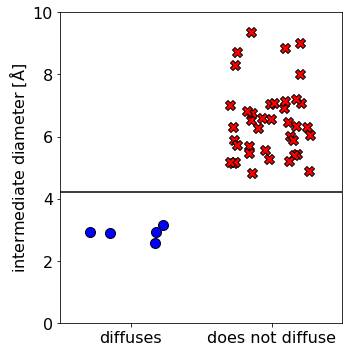

In [10]:
threshold = 4.2
dx = 0.15
fig, ax = plt.subplots(figsize=(5,5))
for name, smile in molecules.items():
    out_file = output_dir+name.replace(' ', '_')+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    results = pd.read_csv(out_file)
    mid_diam = min(results['diam2'])
    if mid_diam <= threshold:
        C = 'b'
        M = 'o'
        E = 'k'
        D = 0.25
    else:
        C = 'r'
        M = 'X'
        E = 'k'
        D = 0.75
    ax.scatter(D+(dx*(np.random.random() - 0.5) * 2),
               mid_diam, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
ax.axhline(y=threshold, c='k')
define_plot_variables(ax,
                      title='',
                      xtitle='',
                      ytitle='intermediate diameter [$\mathrm{\AA}$]',
                      xlim=(0, 1),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"categorical.pdf", dpi=720,
            bbox_inches='tight')

#### Plot shapes

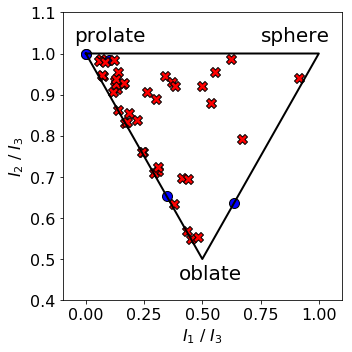

In [14]:
threshold = 4.2
fig, ax = plt.subplots(figsize=(5,5))
for name, smile in molecules.items():
    out_file = output_dir+name.replace(' ', '_')+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    results = pd.read_csv(out_file)
    mid_diam = min(results['diam2'])
    if mid_diam <= threshold:
        C = 'b'
        M = 'o'
        E = 'k'
        D = 0.25
    else:
        C = 'r'
        M = 'X'
        E = 'k'
        D = 0.75
    ax.scatter(np.average(results['ratio_1']),
               np.average(results['ratio_2']),
               c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
ax.plot([0, 0.5, 1, 0], [1, 0.5, 1, 1], c='k', lw=2)
ax.text(0.75, 1.03, 'sphere', fontsize=20)
ax.text(0.4, 0.45, 'oblate', fontsize=20)
ax.text(-0.05, 1.03, 'prolate', fontsize=20)
define_parity_plot_variables(ax,
                             title='',
                             xtitle='$I_1$ / $I_3$',
                             ytitle='$I_2$ / $I_3$',
                             xlim=(-0.1, 1.1),
                             ylim=(0.4, 1.1))
fig.tight_layout()
fig.savefig(output_dir+"shape.pdf", dpi=720,
            bbox_inches='tight')

# Collect reactant-product systems 
- curently as species specific for test case
    - generalize to all available reaction systems
- need general code for reading the BRENDA file lines and getting reactants and products and meta
- need general code for outputting these as reaction systems (to JSON?)
- need general code for interfacing reaction systems into SMILES (using the name in BRENDA) and collecting
    - molecule size
    - cost?

In [12]:
from IPython.display import clear_output

In [15]:
print('Screen all Enzymes in EC Classes using BRENDA data')
count_done = 0
total_start_time = time.time()
for EC_file in database_names:
    if EC_file != '/home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_7__BRENDA_sequences.fasta':
        continue
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    print('-----------------------------------------------')
    print('doing:', EC_file)
    file_mod = EC_file.replace(".fasta", "_mod.fasta")
    EC_pi_data = pi_data[pi_data['fasta_file'] == file_mod]
    # only keep those that pass the pI test
    pi_passed_data = EC_pi_data[EC_pi_data['pi'] < param_dict['cutoff_pi']]
    print('--- ', 
          len(pi_passed_data), 'proteins out of', len(EC_pi_data), 
          'remain, OR', int(len(pi_passed_data)/len(EC_pi_data)*100),
          "% ---")
    EC_no = list(set(EC_pi_data['EC.code']))[0].replace(' ', '').replace(".", "_")
    print('EC:', EC_no.replace("_", "."))
    br_datafile = 'brenda_download_'+EC_no+'.txt'
    # convert br_datafile into dictionary
    br_symbols, br_data = brenda_IO.get_brenda_dict(param_dict['BRENDA_DB_loc']+br_datafile)
    # from here is quite bio-min assay literature specific
    # - although the code can be reused
    # get species of interest from known EC records
    ## when generalizing - we want to remove this for loop
    species_of_interest = EC_set[EC_no.replace('_', '.')]
    for spec in species_of_interest:
        print('species:', spec)
        spec_in_seq, spec_in_br = brenda_IO.is_species_reported(spec, 
                                                                EC_pi_data, 
                                                                br_data, 
                                                                verbose=True)
        # get protein numbers associated with species
        PR_of_int = []
        for i in sorted(br_data['PR']):
            if spec in i.lower():
                # this assumes that the first item of each line is always "#"
                PR_info = i.split("#")[1]            
                if PR_info not in PR_of_int:
                    PR_of_int.append(PR_info)
        print('when you want to go species unspecific you set PR_of_int to None and loop over all.')
        # get reaction systems from BRENDA
        prop_of_int = 'SP'
        list_of_int = br_data[prop_of_int]
        EC_prop_PR_codes = brenda_IO.get_prop_PR_codes(list_of_int)
        value_of_int = {}
        ## when generalizing - we want to remove this for loop
        for PR in PR_of_int:
            if PR in set([j for i in EC_prop_PR_codes.values() for j in i ]):
                print('protein code:', PR, 'has', prop_of_int, 'in BRENDA')
            else:
                print('protein code:', PR, 'does not have', prop, 'in BRENDA')
            values = [list_of_int[i]
                      for i in EC_prop_PR_codes.keys() if PR in EC_prop_PR_codes[i]]
            count = 0
            # iterate over all lines of BRENDA file with PR in SP initial
            for val in values:
                #if '3-(4-hydroxyphenyl)propanoic' not in val:
                #    continue
                print(val)
                print('############################')
                # split val into sections and remove preceding sections to avoid
                # confusion
                PR_sect = val.split("# ")[0]+"# "
                val = val.replace(PR_sect, '')
                rxn_sect = val.split(" (")[0].split(" <")[0]
                val = val.replace(rxn_sect, '')
                meta_sect = val
                # output dictionary
                reaction_system = brenda_IO.Reaction_system(EC_no, prop_of_int, PR, str(count))
                # get all PR associated with rxn system
                # strip value of anything in the first pair of "#" >> as PR codes
                t_assoc_PR = PR_sect.split("#")[1].split(',')
                # check for new lines and split string into list
                reaction_system.assoc_PR = brenda_IO.check_new_lines_and_split(t_assoc_PR)
                # strip value of anything in "(" and ")" >> as meta
                reaction_system.meta = meta_sect
                # split meta info into:
                # references 
                # references for an entry in BRENDA are within "<" and ">"
                t_assoc_refs = val.split(" <")[-1]
                t_assoc_refs = t_assoc_refs.split(">")[0].split(',')
                reaction_system.assoc_refs = brenda_IO.check_new_lines_and_split(t_assoc_refs)
                # reversible?
                # for the "SP" entries - a 'r' enclosed in "{" and "}"
                # implies reversible
                if '{r}' in reaction_system.meta:
                    reaction_system.reversible = True
                # reaction catalysed and reaction type
                reaction_system.extract_general_rxn_info(br_data)

                # make into function -- extract_reactants_products
                # get reactants as before '=' and products as after
                react, prod = rxn_sect.split("=")
                # separate react and prod into molecules by "+"
                r_mol = react.split("+")
                p_mol = prod.split("+")
                # remove preceding and succeeding white space from all molecule names
                r_mol = [i.lstrip().rstrip() for i in r_mol]
                p_mol = [i.lstrip().rstrip() for i in p_mol]
                #####

                # add flags to reaction system for informaton also available in BRENDA
                # no. subunits
                reaction_system.extract_subunit_info(br_data, PR)
                # post translational mods
                reaction_system.extract_PTM(br_data, PR)
                # cofactors
                reaction_system.extract_cofactor_info(br_data, PR)
                # activation cmpds?
                reaction_system.extract_activating_mol(br_data, PR)

                reaction_system.react_mol = r_mol
                reaction_system.prod_mol = p_mol
                
                reaction_system.print_rxn_system()
                input('done?')
                clear_output()
                # output reacion system to file
                # prefix + EC + property + PR code in BRENDA + count of associated files .pkl
                pickle_name = reaction_system.pickle_name
                # pickle reaction system object
                reaction_system.save_object(output_dir+pickle_name)
                count += 1

            break
            if len(values) > 0:
                value_of_int[PR] = values
    count_done += 1
print('--- finished %s EC classes in %s seconds ---' % (count_done, '{0:.2f}'.format(time.time() - total_start_time)))

#12,52# esculetin + H2O2 = ? (#52# demonstration, that esculetin is no
inhibitor, but a substrate of mushroom polyphenol oxidase (PPO) and
horseradish peroxidase (POD) <83>) <28,83>

############################
--------------------------
Reaction system in: RS-1_11_1_7-SP_52_2.pkl
Reaction Catalysed:
['2 phenolic donor + H2O2 = 2 phenoxyl radical of the donor + 2 H2O']
Reaction Type:
['redox reaction', 'oxidation', 'reduction', 'hydroxylation']
--------------------------
Reactants: esculetin + H2O2 -------->
Products: ?
Activating Molecules: melamine OR 2-aminothiazole
--------------------------
No. Sub units = ['?', 'monomer']
Reversible?: None
Co factors?: True
Cofactor Molecules: heme
Post Translational Mods?: ['glycoprotein']
--------------------------
Meta (in full):
 (#52# demonstration, that esculetin is no
inhibitor, but a substrate of mushroom polyphenol oxidase (PPO) and
horseradish peroxidase (POD) <83>) <28,83>

References: ['28', '83']
--------------------------


KeyboardInterrupt: 

In [9]:
file_t = '/home/atarzia/psp/sequence_db/bio_min_dataset/3_1_1_6__BRENDA_sequences_mod.fasta'
temp1 = pi_data[pi_data['fasta_file'] == file_t]
temp2 = temp1[temp1['species'] == ' Vibrio parahaemolyticus V-223/04 ']
print(temp2)

                                                fasta_file acc.code  \
1305091  /home/atarzia/psp/sequence_db/bio_min_dataset/...  Z2DBW5    
1305092  /home/atarzia/psp/sequence_db/bio_min_dataset/...  Z2DBW5    
1305123  /home/atarzia/psp/sequence_db/bio_min_dataset/...  Z2EP46    

                 organism    EC.code                             species  \
1305091   acetylesterase    3.1.1.6    Vibrio parahaemolyticus V-223/04    
1305092   acetylesterase    3.1.1.6    Vibrio parahaemolyticus V-223/04    
1305123   acetylesterase    3.1.1.6    Vibrio parahaemolyticus V-223/04    

            note    pi  modification  category  
1305091   TrEMBL  6.38             0         1  
1305092   TrEMBL  6.38             1         1  
1305123   TrEMBL  5.79             0         0  


In [10]:
temp1.loc[1305123]['species']

' Vibrio parahaemolyticus V-223/04 '

##  load in reaction system

In [38]:
# load in reaction system from pickle file
new_reaction_system = brenda_IO.Reaction_system.load_object(output_dir+pickle_name)

In [39]:
new_reaction_system.print_rxn_system()

--------------------------
Reaction system in: RS-1_11_1_7-SP_52_0.pkl
Reaction Catalysed:
['2 phenolic donor + H2O2 = 2 phenoxyl radical of the donor + 2 H2O']
Reaction Type:
['redox reaction', 'oxidation', 'reduction', 'hydroxylation']
--------------------------
Reactants: guaiacol + H2O2 -------->
Products: tetraguaiacol + H2O
Activating Molecules: melamine OR 2-aminothiazole
--------------------------
No. Sub units = ['?', 'monomer']
Reversible?: None
Co factors?: True
Cofactor Molecules: heme
Post Translational Mods?: ['glycoprotein']
--------------------------
Meta (in full):
(#64# 100% activity <80>; #83# 100% activity with guaiacol at 25 mM
<105>; #44# 74% activity compared to
2,2-azino-bis-(3-ethyl-6-benzothiazolinsulfonate) <82>; #82# shows high
efficiency of interaction with guaiacol at 25 mM <105>; #30# 100%
activity, high efficiency of interaction with guaiacol at 25 mM <105>;
#52# optimal concentrations of guaiacol and H2O2 are 0.5 mM and 0.3 mM,
respectively <139>)
<5,6,

## collect SMILES from common name from Brenda

### CHEMBL

In [43]:
available_resources = [resource for resource in dir(new_client) if not resource.startswith('_')]
print(available_resources)
print(len(available_resources))

# molecule handler
molecule = new_client.molecule
molecule.set_format('json')

# get molecule using unambiguous
m3 = molecule.get('CC(=O)Oc1ccccc1C(=O)O')

# batch queries
records3 = molecule.get(['CNC(=O)c1ccc(cc1)N(CC#C)Cc2ccc3nc(C)nc(O)c3c2',
            'Cc1cc2SC(C)(C)CC(C)(C)c2cc1\\N=C(/S)\\Nc3ccc(cc3)S(=O)(=O)N',
            'CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H]3CCCN3C(=O)C(CCCCN)CCCCN)C(C)(C)C)C(=O)O'])

['activity', 'assay', 'atc_class', 'binding_site', 'biotherapeutic', 'cell_line', 'chembl_id_lookup', 'compound_record', 'compound_structural_alert', 'description', 'document', 'document_similarity', 'document_term', 'drug', 'drug_indication', 'go_slim', 'image', 'mechanism', 'metabolism', 'molecule', 'molecule_form', 'official', 'organism', 'protein_class', 'similarity', 'source', 'substructure', 'target', 'target_component', 'target_prediction', 'target_relation', 'tissue', 'xref_source']
33


In [44]:
from chembl_webresource_client.new_client import new_client
molecule = new_client.molecule
res = molecule.search('vinylacetyl-CoA')  # 'viagra')
# guaiacol

In [45]:
print(res[0]['molecule_chembl_id'])
print(res[0]['molecule_structures']['canonical_smiles'])
print('there are', len(res), 'top search candidates:')
for i in range(len(res)):
    print('option:', i, 'name:', res[i]['pref_name'])
    print([res[i]['molecule_synonyms'][j]['synonyms'] for j in range(len(res[i]['molecule_synonyms']))])

TypeError: 'NoneType' object is not subscriptable

##  SABIO-RK
http://sabiork.h-its.org/layouts/content/docuRESTfulWeb/searchPython.gsp

In [11]:
# set EC 
EC = "1.1.1.1"
# get all SABIO entries
entries = SABIO_IO.get_entries_per_EC(EC)

758 matching entries found.


In [17]:
# iterate over entries
eID = entries[1]
print('entry:', eID)
# initialise reaction system object
rxn_syst = SABIO_IO.SABIO_reaction(EC, eID)
# get reaction ID
rxn_syst.organism, rxn_syst.rID = SABIO_IO.get_rxnID_from_eID(eID)
# get reaction system
rxn_syst.get_reaction_system()
rxn_syst.print_rxn_system()
# append compound information
for m in rxn_syst.components:
    m.get_cmpd_information()
    
# pickle reaction system object to file
# prefix (sRS for SABIO) + EC + EntryID .pkl
rxn_syst.save_object(output_dir+rxn_syst.pkl_name)

entry: 11021
--------------------------
EC: 1.1.1.1
Organism: Coturnix coturnix japonica
SABIO entry ID: 11021
SABIO reaction ID: 8784
--------------------------
Cyclohexanone  (ID: 5081) as Product
NADH  (ID: 38) as Product
H+  (ID: 39) as Product
NAD+  (ID: 37) as Substrate
Cyclohexanol  (ID: 5279) as Substrate
--------------------------
sRS-1_1_1_1-11021.pkl


In [28]:
# iterate over entries
eID = entries[1]
print('entry:', eID)
# initialise reaction system object
rxn_syst = SABIO_IO.SABIO_reaction(EC, eID)
# load in rxn system
rxn_syst = rxn_syst.load_object(output_dir+rxn_syst.pkl_name)
rxn_syst.print_rxn_system()

entry: 11021
loading: /home/atarzia/psp/sequence_db/bio_min_dataset/sRS-1_1_1_1-11021.pkl
--------------------------
EC: 1.1.1.1
Organism: Coturnix coturnix japonica
SABIO entry ID: 11021
SABIO reaction ID: 8784
--------------------------
Cyclohexanone  (ID: 5081) as Product
NADH  (ID: 38) as Product
H+  (ID: 39) as Product
NAD+  (ID: 37) as Substrate
Cyclohexanol  (ID: 5279) as Substrate
--------------------------


## BKMS

In [16]:
import pandas as pd

In [15]:
bkms_dir = '/home/atarzia/psp/BKMS_react/'

In [132]:
# NaNs in Remark column replaced with 999 - all others remain
bkms_data = pd.read_table(bkms_dir+'Reactions_BKMS.tab', delimiter='\t', 
                          names=['ID', 'EC', 'Rec. Name', 'rxn', 
                                 'RID_Brenda', 'RID_KEGG', 'RID_metacyc', 'RID_SABIO',
                                 'Brenda_pathway_name', 'KEGG_pathway_ID', 'KEGG_pathway_name',
                                 'metacyc_pathway_id', 'metacyc_pathway_name', 'stoich_check',
                                 'missing substrate', 'missing product', 'KEGG_comments', 
                                 'metacyc_comments', 'remark']).fillna(value={'remark': 999})

print("BKMS Stats:")
print("The table contains actual data of BRENDA (release 2018.2, only reactions",
      "with naturally occuring substrates), MetaCyc (version 21.5), SABIO-RK",
      "(02/05/2018) and KEGG data, downloaded 23/04/2012. (Downloading more",
      "recent KEGG data cannot be offered because a KEGG license agreement",
      "would be necessary.)", sep='\n')
print('----------------')
print("independant EC No.:", len(list(set(bkms_data['EC']))))
print("independant Rxns:", len(bkms_data['EC']))
print("independant non-generic Rxns:", len([i for i in list(bkms_data['remark'][bkms_data['remark'] != 999]) if 'generic' not in i]))

BKMS Stats:
The table contains actual data of BRENDA (release 2018.2, only reactions
with naturally occuring substrates), MetaCyc (version 21.5), SABIO-RK
(02/05/2018) and KEGG data, downloaded 23/04/2012. (Downloading more
recent KEGG data cannot be offered because a KEGG license agreement
would be necessary.)
----------------
independant EC No.: 6976
independant Rxns: 31740
independant non-generic Rxns: 26103


In [222]:
def get_DB_prop(DB=None):
    """Returns properties of available DBs.
    
    {DB: (directory, class initalized object specific to DB)}
    
    """
    
    DBs = {
         'CHEBI': ('/home/atarzia/psp/molecule_DBs/chebi/', '_'),
        
          }
    if DB is None:
        return DBs
    else:
        try:
            return {DB: DBs[DB]}
        except KeyError:
            print("Error: This DB does not exist.")
            print('available DBs:')
            print(list(DBs.keys()))

In [248]:
# chebi specific definitions and functions
compounds_file = db_dir+'compounds.tsv'
names_file = db_dir+'names.tsv'

def search_for_compound(file, cmpd):
    """Search compounds.tsv file for matching name.
    
    """
    # read file line by line
    # header = 'ID', 'STATUS', 'CHEBI_ACCESSION', 
    #          'SOURCE', 'PARENT_ID', 'NAME', 
    #          'DEFINITION', 'MODIFIED_ON', 'CREATED_BY', 'STAR'
    # dont use pandas - code worked though:
    # cmpds_data = pd.read_table(compounds_file, delimiter='\t', chunksize=1000)
    with open(file, 'r') as f:
        for line in f:
            line_split = line.split('\t')
            ID, _, _, _, parent_id, name, _, _, _, star = line_split
            if ID == 'ID':
                continue
            if name == cmpd:
                return ID, parent_id, name, star
    
    return None


def search_for_name(file, cmpd):
    """Search names.tsv file for matching name.
    
    """
    # read file line by line
    # header = 'ID', 'COMPOUND_ID', 'TYPE', 
    #          'SOURCE', 'NAME', 'ADAPTED', 'LANGUAGE'

    # dont use pandas - code worked though:
    # cmpds_data = pd.read_table(compounds_file, delimiter='\t', chunksize=1000)
    with open(file, 'r') as f:
        for line in f:
            line_split = line.split('\t')
            ID, C_ID, _, _, name, _, _ = line_split
            if ID == 'ID':
                continue
            if name == cmpd:
                return C_ID, name
    
    return None


def convert_nameID_to_parent(file, nameID):
    """Make sure ID extracted for the name is parent - get CHEBI ID of parent if not.
    
    """
    # read file line by line
    # header = 'ID', 'STATUS', 'CHEBI_ACCESSION', 
    #          'SOURCE', 'PARENT_ID', 'NAME', 
    #          'DEFINITION', 'MODIFIED_ON', 'CREATED_BY', 'STAR'
    # dont use pandas - code worked though:
    # cmpds_data = pd.read_table(compounds_file, delimiter='\t', chunksize=1000)
    with open(file, 'r') as f:
        for line in f:
            line_split = line.split('\t')
            ID, _, _, _, parent_id, name, _, _, _, star = line_split
            if ID == 'ID':
                continue
            if nameID == ID:
                if parent_id != 'null':
                    desired_parent_id = parent_id
                    break
                else:
                    return ID, parent_id, name, star
    
    # now search for parent if necessary
    with open(file, 'r') as f:
        for line in f:
            line_split = line.split('\t')
            ID, _, _, _, parent_id, name, _, _, _, star = line_split
            if ID == 'ID':
                continue
            if ID == desired_parent_id:
                if parent_id == 'null':
                    return ID, parent_id, name, star
    
    return None

In [251]:
def get_SMILES_for_molecule_list(mol_list, DBs='any'):
    """Convert list of molecule names to Canonical SMILEs by searching DBs.
    
    Keywords:
        mol_list (list) - list of molecule names
        DBs (str) - DB to use, defaults to a hierachical search through all available
    
    DBs available (online.offline) (in 'any' order):
        - CHEBI (offline) - not yet
        - CHEMBL (online) - not yet
        - SABIO (online) - not yet
        - KEGG (online) - not yet
    
    Returns:
        mol_dict (dict) - {name: (SMILEs, DB, DB_ID, iupac_name)} 
            DB_ID is the molecule ID within the given DB.
    
    """
    mol_dict = {}
    
    # get properties of DBs
    DB_prop = get_DB_prop(DB=DBs)
    
    # chebi code - temp
    compounds_file = db_dir+'compounds.tsv'
    names_file = db_dir+'names.tsv'
    
    for mol in mol_list:
        print(mol)
        # search for name in compound file
        res = search_for_compound(compounds_file, mol)
        if res is None:
            # search for formula in names file
            res = search_for_name(names_file, mol)
            if res is None:
                print('no match in DB')
                continue
            else:
                ID, name = res
                parent_id = None
        else:
            ID, parent_id, name, star = res
        
        # make sure is parent compound
        if parent_id != 'null':
            res = convert_nameID_to_parent(compounds_file, nameID=ID)
            if res is None:
                print("this should not happen - error with cross reference")
                print('check this!')
                import sys
                sys.exit()
            ID, parent_id, name, star = res
        
        # get structure using CHEBI ID
        # structures.csv - read in, get COMPOUND ID match then extract the structure
        # read into RDKIT straight up OR save the SMILE or save a pickle
        # mol_dict should refeence the SMILES or the file its saved to.
        
        smile = ''
        DB = DBs  # temp
        DB_ID = ID
        iupac_name = name
        mol_dict[mol] = (smile, DB, DB_ID, iupac_name)
    
    
    return mol_dict

In [252]:
for idx, row in bkms_data.iterrows():
    # target EC No. of interest
    if row['EC'] != '1.11.1.7':
        continue
    # ignore those with 'generic' in remark
    if 'generic' in row['remark']:
        continue
    # ignore those with missing substrates
    if pd.isna(row['missing substrate']) is False:
        continue
    print(row['ID'], ":", row['EC'], ":", row['Rec. Name'])
    print("reaction:", row['rxn'])
    print(row)
    reactants, products = row['rxn'].split("=")
    reactants = reactants.split("+")
    products = products.split("+")
    # remove white space
    reactants = [i.replace(" ", "") for i in reactants]
    products = [i.replace(" ", "") for i in products]
    print(reactants)
    print(products)
    
    # get SMILES of reactants and products
    reactants_dict = get_SMILES_for_molecule_list(mol_list=reactants, DBs='CHEBI')
    products_dict = get_SMILES_for_molecule_list(mol_list=products, DBs='CHEBI')
    print(reactants_dict)
    print(products_dict)
    break
    
    

8220 : 1.11.1.7 : peroxidase
reaction: H2O2 + methanol = formaldehyde + H2O
ID                                                              8220
EC                                                          1.11.1.7
Rec. Name                                                 peroxidase
rxn                             H2O2 + methanol = formaldehyde + H2O
RID_Brenda                                                  BS373379
RID_KEGG                                                      R00602
RID_metacyc                                                RXN-14189
RID_SABIO                                                        NaN
Brenda_pathway_name                                              NaN
KEGG_pathway_ID                                              rn01120
KEGG_pathway_name       Microbial metabolism in diverse environments
metacyc_pathway_id                                               NaN
metacyc_pathway_name                                             NaN
stoich_check               

In [157]:
import gzip

# reads a zipped SDF file
# not useful for CHEBI because their SDF format varies.
db_dir = '/home/atarzia/psp/molecule_DBs/chebi/'
z_SDF_file = gzip.open(db_dir+'ChEBI_complete.sdf.gz')
suppl = Chem.ForwardSDMolSupplier(z_SDF_file)

for mol in suppl:
    if mol is None: continue
    print(mol.GetNumHeavyAtoms())
    break

RDKit WARNING: [23:28:58]  S group MUL ignored on line 762
RDKit ERROR: [23:28:58]  Unhandled CTAB feature: S group SRU on line: 1122. Molecule skipped.


AttributeError: 'NoneType' object has no attribute 'GetNumHeavyAtoms'

In [155]:
mol.GetNumHeavyAtoms()

21

In [138]:
# RDKIT code to read SDF:
# https://chemistry.stackexchange.com/questions/54861/open-source-sdf-chemical-table-file-parser-in-any-language


from rdkit.Chem import PandasTools


my_sdf_file = '/Users/curt/Desktop/sdf-isothiocyanates.sdf'

frame = PandasTools.LoadSDF(my_sdf_file,
                            smilesName='SMILES',
                            molColName='Molecule',
                            includeFingerprints=False)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/curt/Desktop/sdf-isothiocyanates.sdf'